<a href="https://colab.research.google.com/github/ericodle/J_PlanktoNET/blob/main/exploratory_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load the image files into your working environment. Here, I'm using my Google Drive account.

In [1]:
#Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


If there is a GPU available, this line makes it the default device. If no GPU is available, a CPU will be used instead.

In [ ]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Load dependency libraries

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.datasets.folder import default_loader
import os
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

Define the models used for this analysis. Here, we use VGG16 along with custom Encoder and Decoder classes I wrote to train via unsupervised learning.

In [2]:
# Load the pre-trained VGG16 model
vgg_model = models.vgg16(pretrained=True)

# Define the size of the hidden layer and latent space
hidden_size = 256
latent_size = 128

# Get the output size of the last layer of the VGG16 model
output_size = vgg_model.classifier[6].in_features


class Encoder(nn.Module):
    def __init__(self, encoded_size=128):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)
        self.fc = nn.Linear(encoded_size*784, 512)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class Decoder(nn.Module):
    def __init__(self, encoded_size):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(512, 1024)
        self.fc2 = nn.Linear(1024, 3 * 224 * 224)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = x.view(x.size(0), 3, 224, 224)
        return x

# Create a custom dataset without relying on ImageFolder structure
class UnsupervisedDataset(torch.utils.data.Dataset):
    def __init__(self, folder_path, transform):
        self.folder_path = folder_path
        self.transform = transform
        self.images = self.load_images()

    def load_images(self):
        images = []
        loader = default_loader
        for filename in os.listdir(self.folder_path):
            if filename.endswith('.png'):
                img_path = os.path.join(self.folder_path, filename)
                img = loader(img_path)
                if self.transform is not None:
                    img = self.transform(img)
                images.append(img)
        return images

    def __getitem__(self, index):
        img = self.images[index]
        return img

    def __len__(self):
        return len(self.images)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Point to the location where the target images are saved. I also define the image transformation parameters in this cell.

In [3]:
# Define the path to the folder containing the PNG images
data_path = "/content/drive/MyDrive/D20230307T053258_IFCB108"


# Define the transformation to be applied to each image
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images to a specific size
    transforms.ToTensor(),  # Convert the images to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize the images
])

Instantiate the UnsupervisedDataset class with our images, then make a training dataloader for...training.

In [5]:
# Create the unsupervised dataset
dataset = UnsupervisedDataset(folder_path=data_path, transform=transform)

# Create the training dataloader
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True) # batch size = 1 due to colab memory restrictions

Training loop. Pretty standard code for PyTorch.

In [ ]:
num_epochs = 10

train_losses = []

encoded_size = 128
encoder = Encoder(encoded_size).to(device)
decoder = Decoder(encoded_size).to(device)

# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.001)

# Training loop
for epoch in range(num_epochs):
    for images in train_dataloader:
        # Move images to the same device as model parameters
        images = images.to(device)
        #print("images shape: ", images.shape)

        # Encode
        encoded = encoder(images)
        #print("encoded shape: ", encoded.shape)

        # Reconstruct
        reconstructed = decoder(encoded)
        #print("reconstructed shape: ", reconstructed.shape) #image dims need to be 224

        # Calculate the reconstruction loss
        loss = criterion(reconstructed, images)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print the loss after every epoch
    train_losses.append(loss.item())
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

# Save the trained model parameters
torch.save(encoder.state_dict(), "encoder.pth")
torch.save(decoder.state_dict(), "decoder.pth")

Epoch [1/10], Loss: 0.028849778696894646
Epoch [2/10], Loss: 0.010305807925760746
Epoch [3/10], Loss: 0.01916063018143177
Epoch [4/10], Loss: 0.008741011843085289
Epoch [5/10], Loss: 0.021915411576628685
Epoch [6/10], Loss: 0.011516614817082882
Epoch [7/10], Loss: 0.022804563865065575
Epoch [8/10], Loss: 0.04564661532640457
Epoch [9/10], Loss: 0.018278200179338455
Epoch [10/10], Loss: 0.029975900426506996


Take a look at the training losses, more out of habit than necessity since the absence of one-hot encoded data makes the loss progression uninformative (feel free to fact check me on that).

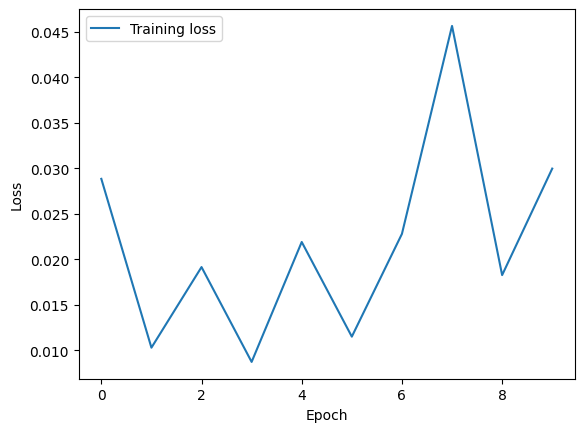

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

We have now trained our Encoder-Decoder set on the images obtained from Flow Cytobot. The point of that was to extract meaningful clustering patterns from the trained parameters, thus auto-classifying our images into similar groups.

In [6]:
# Re-initialize Encoder
encoder = Encoder()
encoder.load_state_dict(torch.load('/content/drive/MyDrive/encoder.pth', map_location=torch.device('cpu')))
encoder.to(device)

# Re-initialize Decoder
#decoder = Decoder()
#decoder.load_state_dict(torch.load('/content/drive/MyDrive/decoder.pth', map_location=torch.device('cpu')))
#decoder.to(device)

Encoder(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (fc): Linear(in_features=100352, out_features=512, bias=True)
)

Re-load the images for model testing. I chose to make separate train_ and test_dataloader variables for future flexability if needed.

In [7]:
import torch
from torch.utils.data import DataLoader

# Create a DataLoader for your dataset
test_dataloader = DataLoader(dataset, batch_size=1, shuffle=False) # batch size = 1 due to colab memory restrictions

# Set the encoder to evaluation mode
encoder.eval()

# Initialize an empty list to store the encoded features
encoded_features = []

# Pass the data through the Encoder and extract the encoded features
with torch.no_grad():
    for images in test_dataloader:
        images = images.to(device)
        
        # Forward pass through the Encoder
        encoded = encoder(images)
        
        # Append the encoded features to the list
        encoded_features.append(encoded.cpu())
    
# Concatenate the encoded features from all batches
encoded_features = torch.cat(encoded_features, dim=0)

# Print the shape of the encoded features
print("encoded_features shape:", encoded_features.shape)

encoded_features shape: torch.Size([4239, 512])


Silhouette Analysis is a method to determine the suitability of a cluster set size. For example, if data clusters better among 4 groups rathern than 3, Silhouette Analysis should reveal that.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters = 2, Silhouette score = 0.7453630566596985


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters = 3, Silhouette score = 0.5395548343658447


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters = 4, Silhouette score = 0.5168637037277222


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters = 5, Silhouette score = 0.4938139021396637


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters = 6, Silhouette score = 0.49860382080078125


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters = 7, Silhouette score = 0.45804068446159363


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters = 8, Silhouette score = 0.45693862438201904


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters = 9, Silhouette score = 0.4373115599155426


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters = 10, Silhouette score = 0.4369805157184601


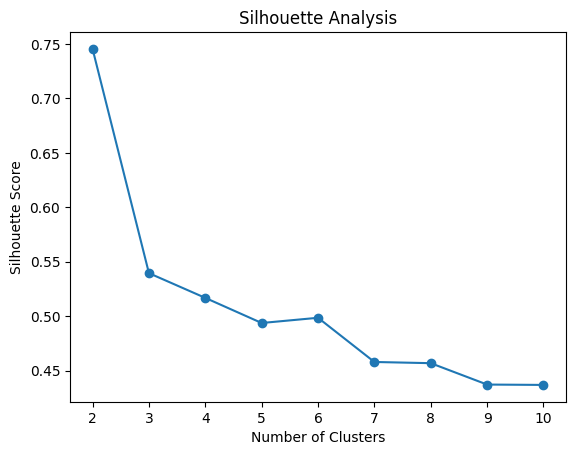

In [8]:
# Initialize an empty list to store silhouette scores for different numbers of clusters
silhouette_scores = []

# Define the range of number of clusters to try
min_clusters = 2
max_clusters = 10

# Perform silhouette analysis for each number of clusters
for n_clusters in range(min_clusters, max_clusters+1):
    # Perform clustering using any clustering algorithm of your choice (e.g., KMeans)
    clusterer = KMeans(n_clusters=n_clusters)
    labels = clusterer.fit_predict(encoded_features)
    
    # Calculate the silhouette score for the current number of clusters
    silhouette_avg = silhouette_score(encoded_features, labels)
    silhouette_scores.append(silhouette_avg)
    
    # Print the silhouette score for the current number of clusters
    print(f"Number of clusters = {n_clusters}, Silhouette score = {silhouette_avg}")

# Plot the silhouette scores
plt.plot(range(min_clusters, max_clusters+1), silhouette_scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis")
plt.show()


This is as far as I got before crashing Colab.

In [ ]:
# Initialize an empty tensor to store the encoded features
encoded_features = torch.empty(0)

# Iterate over the batches of data
for images in test_dataloader:
    # Forward pass
    encoded = encoder(images.to(device))

    # Concatenate the encoded features from the current batch
    encoded_features = torch.cat((encoded_features, encoded.cpu()), dim=0)

encoded_features = encoded_features.detach().numpy()

# Perform clustering and silhouette analysis
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

kmeans = KMeans(n_clusters=5)  # Adjust the number of clusters as needed
clusters = kmeans.fit_predict(encoded_features)

silhouette_avg = silhouette_score(encoded_features, clusters)
print("Average silhouette score:", silhouette_avg)